In [1]:
import random
import numpy as np
from scipy.optimize import minimize
from qiskit.circuit import ParameterVector
from qiskit import QuantumCircuit, transpile
from VQLS import specialHadamardTest, getBArray, getMatrixCoeffitients, getApproximationValue, plotCost, ansatzTest, hadamardTest
from Utils import createMatrixFromParameters 
from qiskit import Aer
from qiskit.quantum_info import PauliList, SparsePauliOp
import matplotlib.pyplot as plt


In [2]:
costHistory = []
def calculateCostFunctionMatrix(parameters: list, args: list) -> float:
    overallSum1 = 0
    overallSum2 = 0
    # parameters = [parameters[0:3], parameters[3:6], parameters[6:9]]
    coefficientSet = args[0]
    backend = Aer.get_backend("aer_simulator")

    transpiledHadamardCircuits = args[1]
    parametersHadamard = args[2]

    transpiledSpecialHadamardCircuits = args[3]
    parametersSpecialHadamard = args[4]

    qcrs = [i.bind_parameters({parametersHadamard: parameters}) for i in transpiledHadamardCircuits]
    qcrs1 = [i.bind_parameters({parametersSpecialHadamard: parameters}) for i in transpiledSpecialHadamardCircuits]
    lenPaulis = len(qcrs1)

    for i in range(lenPaulis):
        for j in range(lenPaulis):
            # add this when constructing circuits 
            # circ.save_statevector()
            job = backend.run(qcrs[i*lenPaulis + j])
            result = job.result()
            outputstate = np.real(result.get_statevector(qcrs[i*lenPaulis + j], decimals=100))
            o = outputstate

            m_sum = 0
            for l in range(len(o)):
                if l % 2 == 1:
                    n = o[l] ** 2
                    m_sum += n

            multiply = coefficientSet[i] * coefficientSet[j]
            overallSum1 += multiply * (1 - (2 * m_sum))

    resultVectors = []
    for i in range(lenPaulis):
        job = backend.run(qcrs[i*lenPaulis + j])
        #circ.save_statevector()
        result = job.result()
        outputstate = np.real(result.get_statevector(qcrs[i*lenPaulis + j], decimals=100))
        resultVectors.append(outputstate)

    for i in range(lenPaulis):  # optimize it little bit more
        for j in range(lenPaulis):
            mult = 1
            for extra in range(2):
                if extra == 0:
                    o = resultVectors[i]
                if extra == 1:
                    o = resultVectors[j]

                m_sum = 0
                for l in range(len(o)):
                    if l % 2 == 1:
                        n = o[l] ** 2
                        m_sum += n
                mult = mult * (1 - (2 * m_sum))

            multiply = coefficientSet[i] * coefficientSet[j]
            overallSum2 += multiply * mult

    totalCost = 1 - float(overallSum2.real / overallSum1.real)
    # print(totalCost)
    costHistory.append(totalCost)
    return totalCost

In [3]:
def minimization(
    paulis: PauliList,
    coefficientSet: list,
    totalNeededQubits: int,
    bVector: list,
    method: str = "COBYLA",
) -> list:
    global costHistory
    costHistory = []
    backend = Aer.get_backend("aer_simulator")

    x = [float(random.randint(0, 3000)) for _ in range(0, 9)]
    x = x / np.linalg.norm(x)
    parametersHadamard = ParameterVector("parametersHadarmard", 9)
    parametersSpecialHadamard = ParameterVector("parametersSpecialHadamard", 9)
    parametersHadamardSplit = [parametersHadamard[0:3], parametersHadamard[3:6], parametersHadamard[6:9]]
    parametersSpecialHadamardSplit = [parametersSpecialHadamard[0:3], parametersSpecialHadamard[3:6], parametersSpecialHadamard[6:9]]

    hadamardCircuits = []
    specialHadamardCircuits = []

    for i in range(len(paulis)):
        for j in range(len(paulis)):
            circ = QuantumCircuit(totalNeededQubits)
            hadamardTest(circ, [paulis[i], paulis[j]], [1, 2, 3], 0, parametersHadamardSplit)
            circ.save_statevector()
            hadamardCircuits.append(circ)

    transpiledHadamardCircuits = transpile(hadamardCircuits, backend=backend)
    
    for i in range(len(paulis)):
        circ = QuantumCircuit(totalNeededQubits)
        specialHadamardTest(circ, [paulis[i]], [1, 2, 3], 0, parametersSpecialHadamardSplit, bVector)
        circ.save_statevector()
        specialHadamardCircuits.append(circ)

    transpiledSpecialHadamardCircuits = transpile(specialHadamardCircuits, backend=backend)

    out = minimize(
        calculateCostFunctionMatrix,
        x0=x,
        args=[coefficientSet,transpiledHadamardCircuits,  parametersHadamard, transpiledSpecialHadamardCircuits, parametersSpecialHadamard],
        method=method,
        options={"maxiter": 200},
    )
    # print(out)
    return [out["x"][0:3], out["x"][3:6], out["x"][6:9]]



Statevector([ 7.73005568e-02+0.j, -1.68004000e-05+0.j,  4.56981518e-01+0.j,
             -1.24223000e-05+0.j,  6.86256038e-01+0.j, -1.28459000e-05+0.j,
             -5.60575745e-01+0.j,  1.04266000e-05+0.j],
            dims=(2, 2, 2))
[ 7.73005568e-02+0.j -1.68004000e-06+0.j  4.56981518e-01+0.j
 -1.24223000e-06+0.j  6.86256038e-01+0.j -1.28459000e-06+0.j
 -5.60575745e-01+0.j  1.04266000e-06+0.j]
[ 7.73005568e-02+0.j -1.68004000e-06+0.j  4.56981519e-01+0.j
 -1.24223000e-06+0.j  6.86256038e-01+0.j -1.28459000e-06+0.j
 -5.60575745e-01+0.j  1.04266000e-06+0.j]
0.054443268999791544


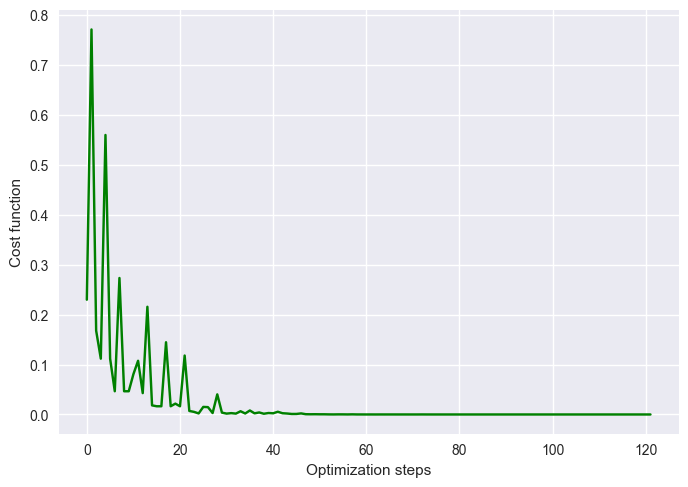

In [4]:
bVector = getBArray([1, 1, 1, 1, 1, 1, 1, 1])
A = createMatrixFromParameters([0.45, 0.55], ["ZII", "III"])

pauliOp = SparsePauliOp.from_operator(A)
paulis = pauliOp.paulis
coefficientSet = getMatrixCoeffitients(pauliOp)

outF = minimization(
    paulis=paulis,
    coefficientSet=coefficientSet,
    totalNeededQubits=pauliOp.num_qubits + 2,
    bVector=bVector,
)
circ = QuantumCircuit(pauliOp.num_qubits, pauliOp.num_qubits)
o = ansatzTest(circ, outF)

print(o)
print(A.dot(o))
print((A.dot(o) / (np.linalg.norm(A.dot(o)))))
print(getApproximationValue(A, bVector, o))
plt.style.use("seaborn-v0_8")
plt.plot(costHistory, "g")
plt.ylabel("Cost function")
plt.xlabel("Optimization steps")
plt.show()

Statevector([-9.75531786e-01+0.j,  1.39701130e-03+0.j,  3.52482300e-04+0.j,
              4.19773970e-03+0.j,  2.19771681e-01+0.j, -1.42869480e-03+0.j,
              7.37353600e-04+0.j,  3.98258390e-03+0.j],
            dims=(2, 2, 2))
[-9.75531786e-01+0.j  7.68356215e-04+0.j  1.93865265e-04+0.j
  4.19773970e-04+0.j  2.19771681e-01+0.j -7.85782140e-04+0.j
  4.05544480e-04+0.j  3.98258390e-04+0.j]
[-9.75549540e-01+0.j  7.68370199e-04+0.j  1.93868793e-04+0.j
  4.19781610e-04+0.j  2.19775681e-01+0.j -7.85796441e-04+0.j
  4.05551861e-04+0.j  3.98265638e-04+0.j]
0.07113498205349583


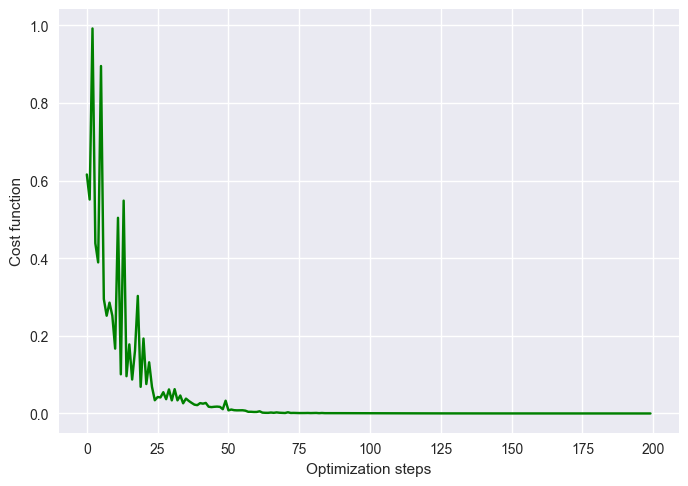

In [5]:
bVector = getBArray([1, 1, 1, 1, 1, 1, 1, 1])
A = createMatrixFromParameters([0.225, 0.225, 0.55], ["ZII", "IZI", "III"])

pauliOp = SparsePauliOp.from_operator(A)
paulis = pauliOp.paulis
coefficientSet = getMatrixCoeffitients(pauliOp)

outF = minimization(
    paulis=paulis,
    coefficientSet=coefficientSet,
    totalNeededQubits=pauliOp.num_qubits + 2,
    bVector=bVector,
)
circ = QuantumCircuit(pauliOp.num_qubits, pauliOp.num_qubits)
o = ansatzTest(circ, outF)

print(o)
print(A.dot(o))
print((A.dot(o) / (np.linalg.norm(A.dot(o)))))
print(getApproximationValue(A, bVector, o))
plt.style.use("seaborn-v0_8")
plt.plot(costHistory, "g")
plt.ylabel("Cost function")
plt.xlabel("Optimization steps")
plt.show()